<a href="https://colab.research.google.com/github/pranjul6386/covid_rfmd/blob/master/research_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/My Drive/kaggle_notebooks/RMFD.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import keras


from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint

In [ ]:
img = cv2.imread('/content/images/nomask/benxi/0_0_benxi_0013.jpg', cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img.shape

 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (127, 125, 3)
Image Height       :  127
Image Width        :  125
Number of Channels :  3


In [ ]:
list_images=[]
labels=[]

In [ ]:
for filename in os.listdir("/content/images/mask"):
  for img in os.listdir("/content/images/mask" + "/" + filename):
    path= str("/content/images/mask" + "/"+ filename + "/" + img)
    try:

      image=cv2.imread(path)
    except:
      print("file not found error")

      continue
    image=cv2.resize(image,(224,224))
    arr=np.array(image)
    list_images.append(arr)
    labels.append("masked")


In [ ]:

len(list_images)

4653

In [ ]:
labels

In [ ]:
for filename in os.listdir("/content/images/nomask"):
  for img in os.listdir("/content/images/nomask" + "/" + filename):
    path= str("/content/images/nomask" + "/"+ filename + "/" + img)
    try:

      image=cv2.imread(path)
    except:
      print("file not found error")

      continue
    image=cv2.resize(image,(224,224))
    arr=np.array(image)
    list_images.append(arr)
    labels.append("unmasked")
    if len(list_images)>2000:
      break

In [ ]:
len(list_images)

2450

In [ ]:
y_train=np.array(labels)
labelencoder=LabelEncoder()
y_train=labelencoder.fit_transform(y_train)

In [ ]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
class ResNet:

	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
   
   
   	# the shortcut branch of the ResNet module should be
	# initialize as the input (identity) data
   shortcut = data
  
  	# the first block of the ResNet module are the 1x1 CONVs
   bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)

   act1 = Activation("relu")(bn1)
   conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)
   	# the second block of the ResNet module are the 3x3 CONVs
	 bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
	 act2 = Activation("relu")(bn2)
	 conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg)(act2)
  	# the third block of the ResNet module is another set of 1x1 CONVs
	 bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
	 act3 = Activation("relu")(bn3)
	 conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
  	# if we are to reduce the spatial size, apply a CONV layer to the shortcut
	 if red:
	    shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, 
	   		 kernel_regularizer=l2(reg))(act1)

	# add together the shortcut and the final CONV
	 x = add([conv3, shortcut])

	# return the addition as the output of the ResNet module
	 return x

  @staticmethod
  def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):


    	# initialize the input shape to be "channels last" and the
	# channels dimension itself
	  inputShape = (height, width, depth)
	  chanDim = -1

	# if we are using "channels first", update the input shape
	# and channels dimension
	  if K.image_data_format() == "channels_first":
		  inputShape = (depth, height, width)
		  chanDim = 1
      		# set the input and apply BN
		  inputs = Input(shape=inputShape)
		  x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			    momentum=bnMom)(inputs)

		# apply CONV => BN => ACT => POOL to reduce spatial size
		  x = Conv2D(filters[0], (5, 5), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)
		  x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		  x = Activation("relu")(x)
		  x = ZeroPadding2D((1, 1))(x)
		  x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    	# loop over the number of stages
	  for i in range(0, len(stages)):
		# initialize the stride, then apply a residual module
		# used to reduce the spatial size of the input volume
		  stride = (1, 1) if i == 0 else (2, 2)
		  x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

		# loop over the number of layers in the stage
		  for j in range(0, stages[i] - 1):
			# apply a ResNet module
			  x = ResNet.residual_module(x, filters[i + 1],
				(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
      	# loop over the number of stages
        	# apply BN => ACT => POOL
	  x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
	  x = Activation("relu")(x)
	  x = AveragePooling2D((8, 8))(x)
    return x

  

In [ ]:
base_model = ResNet50(weights= None, include_top=False, input_shape= (224,224,3))

In [ ]:
x=base_model.output

NameError: ignored

In [ ]:
x

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
base_model.output_shape

(None, 7, 7, 2048)

In [ ]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(5,5),input_shape=(128,128,3),activation="relu",))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(5,5),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_data=np.array(list_images)
print(x_data.shape)

(4652, 128, 128, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_data,y_train, test_size=0.20, shuffle= True)

In [ ]:
y_test.shape

(931,)

In [ ]:

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(x_train,y_train,epochs=100,callbacks=[checkpoint],validation_split=0.2,batch_size=64,verbose=0)

INFO:tensorflow:Assets written to: model-001.model/assets
INFO:tensorflow:Assets written to: model-002.model/assets
INFO:tensorflow:Assets written to: model-006.model/assets
INFO:tensorflow:Assets written to: model-012.model/assets
INFO:tensorflow:Assets written to: model-085.model/assets


In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=64, epochs=100, verbose=0)

In [ ]:
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

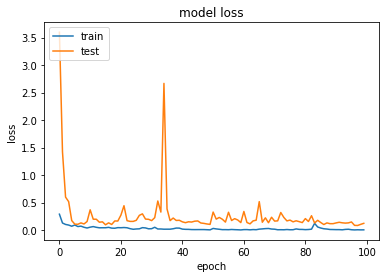

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

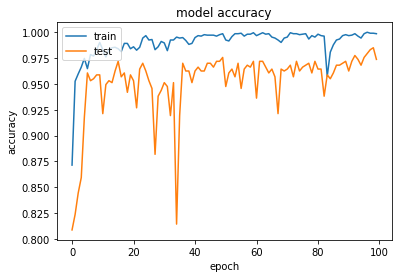

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(train_acc)
print(test_acc)

0.996237576007843
0.9881847500801086


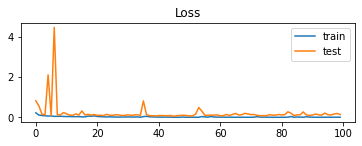

In [ ]:
# plot loss during training
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()


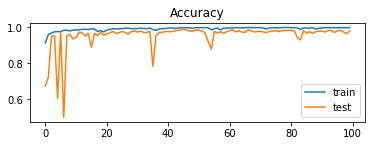

In [ ]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
yhat_classes = model.predict_classes(x_test, verbose=0)
yhat_probs = model.predict(x_test, verbose=0)

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
accuracy = accuracy_score(y_test,yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.979592
Precision: 0.967347
Recall: 0.993711
F1 score: 0.980352
Cohens kappa: 0.959131
ROC AUC: 0.993937
[[438  16]
 [  3 474]]


In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("model_final_rfmd.h5")

In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/drive/My Drive/lfw_masked.rar').extractall('/content')

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
lfw_images=[]
count=0

In [ ]:
for name in os.listdir("/content/lfw_masked/lfw_masked"):
  for img in os.listdir("/content/lfw_masked/lfw_masked"+"/"+name):
    path= str("/content/lfw_masked/lfw_masked" + "/"+ name + "/" + img)
    try:

      image=cv2.imread(path)
      count+=1
    except:
      print("file not found error")

      continue
    image=cv2.resize(image,(128,128))
    arr=np.array(image)
    lfw_images.append(arr)
    if len(lfw_images)>2000:
      break

    

In [ ]:
count

6784

In [ ]:
y_lfw=np.ones((6784,1))

In [ ]:
lfw_x_test=np.array(lfw_images)
lfw_x_test.shape

(6784, 128, 128, 3)

In [ ]:
# accuracy: (tp + tn) / (p + n)
yhat_classes_lfw= model.predict_classes(lfw_x_test, verbose=0)
yhat_probs_lfw = model.predict(lfw_x_test, verbose=0)

yhat_probs_lfw = yhat_probs_lfw[:, 0]
yhat_classes_lfw = yhat_classes_lfw[:, 0]
accuracy = accuracy_score(y_lfw,yhat_classes_lfw)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_lfw, yhat_classes_lfw)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_lfw,yhat_classes_lfw)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_lfw,yhat_classes_lfw)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_lfw,yhat_classes_lfw)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(y_lfw,yhat_classes_lfw)
print(matrix)

Accuracy: 0.000000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
[[   0    0]
 [6784    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_hat=model.predict(lfw_x_test)

In [ ]:
y_hat

array([[7.4759732e-18],
       [1.4331218e-16],
       [9.3767113e-20],
       ...,
       [4.7183143e-17],
       [1.6056265e-16],
       [1.7503679e-15]], dtype=float32)

In [ ]:
yhat_probs_lfw

array([7.4759732e-18, 1.4331218e-16, 9.3767113e-20, ..., 4.7183143e-17,
       1.6056265e-16, 1.7503679e-15], dtype=float32)

In [ ]:
yhat_probs_lfw=yhat_probs_lfw.reshape(6784,1)


In [ ]:
y_prediction=np.zeros((6784,1))
for i in range(yhat_probs_lfw.shape[0]):
  if yhat_probs_lfw[i,0]>0.5:
    y_prediction[i,0]=1
  else:
    y_prediction[i,0]=0

print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction- y_lfw)) * 100))


test accuracy: 0.0 %


In [ ]:
y_pred_class = model.predict(lfw_x_test)
from sklearn import metrics
print(metrics.accuracy_score(y_lfw, y_pred_class))


ValueError: ignored

In [ ]:
y_pred_class.shape

(6784, 1)

In [ ]:
y_lfw.shape

(6784, 1)